# 1-4 Example: Modeling Procedure for Temporal Sequences


The COVID-19 has been lasting for over three months (Note from the translator: until April, 2020) in China and significantly affected the ordinary life.

The impacts could be on the incomes, emotions, psychologies, and weights.

So how long this pandemic is going to last, and when will we be free again?

This example is about predicting the time of COVID-19 termination in China using RNN model established by TensorFlow 2.



### 1. Data Preparation

<!-- #region -->


The dataset is extracted from "tushare". The details of the data acquisition is [here (in Chinese)](https://zhuanlan.zhihu.com/p/109556102).

![](./data/1-4-新增人数.png)

<!-- #endregion -->

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

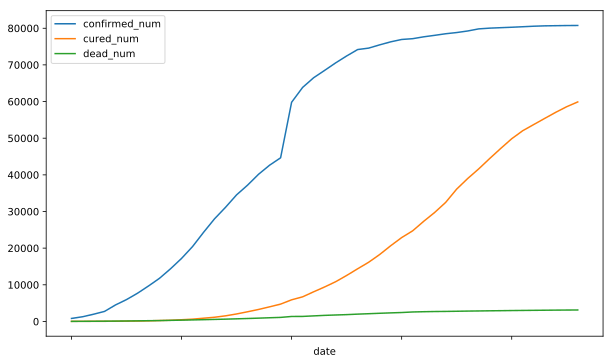

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

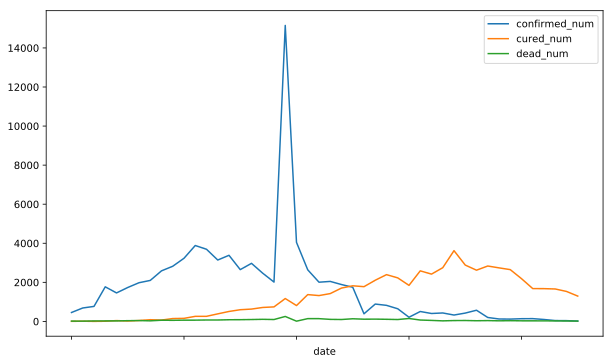

In [4]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [5]:
#Use the data of an eight-day window priorier of the date we are investigating as input for prediction
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#We can put all data into one batch to enhance the performance since the data volume is small.
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

### 2. Model Definition


Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we use API functions for modeling.

In [6]:
#We design the following block since the daily increment of confirmed, discharged and deceased cases are equal or larger than zero.
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [7]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#We design the following block since the daily increment of confirmed, discharged and deseased cases are equal or larger than zero.
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we use the simplist way: using internal function fit.

Note: The parameter adjustment of RNN is more difficult comparing to other types of neural network. We need to try various learning rate to achieve a satisfying result.

In [8]:
#Customized loss function, consider the ratio between square error and the prediction
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [9]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#Half the learning rate if loss is not improved after 100 epoches
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#Stop training when loss is not improved after 200 epoches
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 3.5449
Epoch 2/500
1/1 [==============================] - 0s 40ms/step - loss: 3.3331
Epoch 3/500
1/1 [==============================] - 0s 31ms/step - loss: 3.1533
Epoch 4/500
1/1 [==============================] - 0s 30ms/step - loss: 2.9889
Epoch 5/500
1/1 [==============================] - 0s 33ms/step - loss: 2.8306
Epoch 6/500
1/1 [==============================] - 0s 34ms/step - loss: 2.6721
Epoch 7/500
1/1 [==============================] - 0s 33ms/step - loss: 2.5109
Epoch 8/500
1/1 [==============================] - 0s 32ms/step - loss: 2.3436
Epoch 9/500
1/1 [==============================] - 0s 33ms/step - loss: 2.1688
Epoch 10/500
1/1 [==============================] - 0s 34ms/step - loss: 1.9856
Epoch 11/500
1/1 [==============================] - 0s 32ms/step - loss: 1.7939
Epoch 12/500
1/1 [==============================] - 0s 32ms/step - loss: 1.5946
Epoch 13/500
1/1 [==============================] -

Epoch 104/500
1/1 [==============================] - 0s 26ms/step - loss: 0.4393
Epoch 105/500
1/1 [==============================] - 0s 25ms/step - loss: 0.4392
Epoch 106/500
1/1 [==============================] - 0s 25ms/step - loss: 0.4392
Epoch 107/500
1/1 [==============================] - 0s 26ms/step - loss: 0.4392
Epoch 108/500
1/1 [==============================] - 0s 25ms/step - loss: 0.4391
Epoch 109/500
1/1 [==============================] - 0s 27ms/step - loss: 0.4391
Epoch 110/500
1/1 [==============================] - 0s 26ms/step - loss: 0.4391
Epoch 111/500
1/1 [==============================] - 0s 29ms/step - loss: 0.4390
Epoch 112/500
1/1 [==============================] - 0s 27ms/step - loss: 0.4390
Epoch 113/500
1/1 [==============================] - 0s 32ms/step - loss: 0.4390
Epoch 114/500
1/1 [==============================] - 0s 27ms/step - loss: 0.4389
Epoch 115/500
1/1 [==============================] - 0s 27ms/step - loss: 0.4389
Epoch 116/500
1/1 [=========

1/1 [==============================] - 0s 27ms/step - loss: 0.3989
Epoch 206/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3986
Epoch 207/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3982
Epoch 208/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3979
Epoch 209/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3975
Epoch 210/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3972
Epoch 211/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3968
Epoch 212/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3964
Epoch 213/500
1/1 [==============================] - 0s 31ms/step - loss: 0.3960
Epoch 214/500
1/1 [==============================] - 0s 27ms/step - loss: 0.3956
Epoch 215/500
1/1 [==============================] - 0s 27ms/step - loss: 0.3952
Epoch 216/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3948
Epoch 217/500
1/1 [=======================

Epoch 307/500
1/1 [==============================] - 0s 38ms/step - loss: 0.3295
Epoch 308/500
1/1 [==============================] - 0s 37ms/step - loss: 0.3290
Epoch 309/500
1/1 [==============================] - 0s 36ms/step - loss: 0.3285
Epoch 310/500
1/1 [==============================] - 0s 32ms/step - loss: 0.3280
Epoch 311/500
1/1 [==============================] - 0s 33ms/step - loss: 0.3276
Epoch 312/500
1/1 [==============================] - 0s 32ms/step - loss: 0.3271
Epoch 313/500
1/1 [==============================] - 0s 29ms/step - loss: 0.3267
Epoch 314/500
1/1 [==============================] - 0s 28ms/step - loss: 0.3263
Epoch 315/500
1/1 [==============================] - 0s 36ms/step - loss: 0.3259
Epoch 316/500
1/1 [==============================] - 0s 30ms/step - loss: 0.3255
Epoch 317/500
1/1 [==============================] - 0s 27ms/step - loss: 0.3251
Epoch 318/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3247
Epoch 319/500
1/1 [=========

1/1 [==============================] - 0s 25ms/step - loss: 0.3119
Epoch 409/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3119
Epoch 410/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3118
Epoch 411/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3117
Epoch 412/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3116
Epoch 413/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3116
Epoch 414/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3115
Epoch 415/500
1/1 [==============================] - 0s 25ms/step - loss: 0.3114
Epoch 416/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3113
Epoch 417/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3113
Epoch 418/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3112
Epoch 419/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3111
Epoch 420/500
1/1 [=======================

### 4. Model Evaluation


Model evaluation usually needs both evaluation and testing sets. We only have very few data in this case so we only visualize the changes of loss function during iteration.m

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

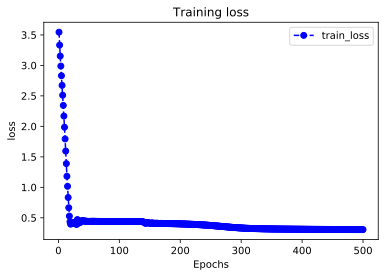

In [12]:
plot_metric(history,"loss")

### 5. Model Application


We predict the time of the end of COVID-19 here, i.e. the date when the daily increment of new confirmed cases = 0.


In [13]:
#This "dfresult" is used to record the current and predicted data
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [14]:
#Predicting the daily increment of the new confirmed cases of the next 100 days; add this result into dfresult
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [15]:
dfresult.query("confirmed_num==0").head()

# From Day 55 the daily increment of the new confirmed cases reduced to zero. Since Day 45 is corresponding to March 10, the daily increment of the news confirmed cases will reduce to 0 in Manch 20.
# Note: this prediction is TOO optimistic

,confirmed_num,cured_num,dead_num
49,0.0,1225.0,-0.0
50,0.0,1202.0,0.0
51,0.0,1178.0,-0.0
52,0.0,1153.0,0.0
53,0.0,1127.0,-0.0


In [17]:
dfresult.query("cured_num==0").head()

# The daily increment of the discharged (cured) cases will reduce to 0 in Day 164, which is about 4 months after March 10 (i.e. July 10) all the patients will be discharged.
# Note: this prediction is TOO pessimistic and problematic: the total sum of the daily increment of discharged cases is larger than cumulated confirmed cases.

,confirmed_num,cured_num,dead_num
108,0.0,0.0,0.0
109,0.0,0.0,-0.0
110,0.0,0.0,0.0
111,0.0,0.0,-0.0
112,0.0,0.0,0.0


In [18]:
dfresult.query("dead_num==0").head()

# The daily increment of the deceased will be reduced to 0 from Day 60, which is March 25, 2020
# Note: This prediction is relatively reasonable.

,confirmed_num,cured_num,dead_num
46,9.0,1282.0,0.0
47,4.0,1265.0,-0.0
48,1.0,1246.0,0.0
49,0.0,1225.0,-0.0
50,0.0,1202.0,0.0



### 6. Model Saving


Model saving with the original way of TensorFlow is recommended.

In [19]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


In [20]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1924.267   ,   96.848145,   33.18102 ],
       [2373.4763  ,   75.93775 ,   67.46807 ],
       [2589.8303  ,  161.78043 ,   63.043934],
       [2963.8662  ,  172.78589 ,   70.78617 ],
       [3562.5066  ,  286.14224 ,   71.892204],
       [3386.4897  ,  287.2428  ,   80.74048 ],
       [2881.3582  ,  425.9117  ,   80.74048 ],
       [3103.2126  ,  561.279   ,   95.11892 ],
       [2431.232   ,  659.2277  ,   98.43702 ],
       [2725.51    ,  695.5458  ,  107.28529 ],
       [2261.6323  ,  786.8912  ,  119.45166 ],
       [1454.1329  ,  804.3946  ,   78.99553 ],
       [5291.848   , 1184.2847  ,   12.980524],
       [1405.9879  ,  804.93335 ,    0.      ],
       [1034.6481  , 1359.6163  ,    0.      ],
       [ 808.18164 , 1311.7936  ,    0.      ],
       [ 817.34644 , 1416.191   ,    0.      ],
       [ 740.13947 , 1702.2753  ,    0.      ],
       [ 676.3047  , 1822.0417  ,    0.      ],
       [ 159.68312 , 1772.6322  ,    0.      ],
       [ 376.54904 , 2101.5405  ,    0. 